# 03a Impact of Miscalibration on PhotoZ

- author Sylvie Dagoret-Campagne
- creation date : 2023/02/26
- last verification : 2023/03/05

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pandas as pd
import copy

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
props = dict(boxstyle='round', facecolor='yellow', alpha=0.3)

In [2]:
from scipy import interpolate
from astropy import constants as const
from astropy import units as u

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

In [3]:
from importlib.metadata import version
the_ver = version('atmosphtransmemullsst')
print(f"Version of atmosphtransmemullsst : {the_ver}")

Version of atmosphtransmemullsst : 0.0.1


In [4]:
import atmosphtransmemullsst
from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

emul = SimpleAtmEmulator(os.path.join(atmosphtransmemullsst.__path__[0],'../data/simplegrid'))

SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [5]:
WL = emul.GetWL()

In [6]:
import sys
sys.path.append('../lib')
import libAtmosphericFit

libAtmosphericFit.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libAtmosphericFit.py :: data_path = /Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [7]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

libPhotometricCorrections.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libPhotometricCorrections :: data_path = /Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [8]:
from rubin_sim.phot_utils import Bandpass, Sed
from rubin_sim.data import get_data_dir
from rubin_sim.phot_utils import PhotometricParameters 
from rubin_sim.site_models import SeeingModel
from rubin_sim.phot_utils import SignalToNoise
from rubin_sim.phot_utils import calc_neff

In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [11]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [12]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

## Configuration

In [13]:
path_rubin_sim_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline")

In [14]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [15]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

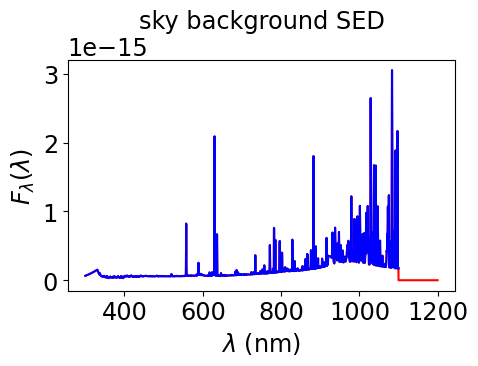

In [16]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

## Chose a Standard atmosphere

In [17]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = -1# Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [18]:
pc = PhotometricCorrections(am0,pwv0,oz0,ncomp,tau0,beta0)

### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

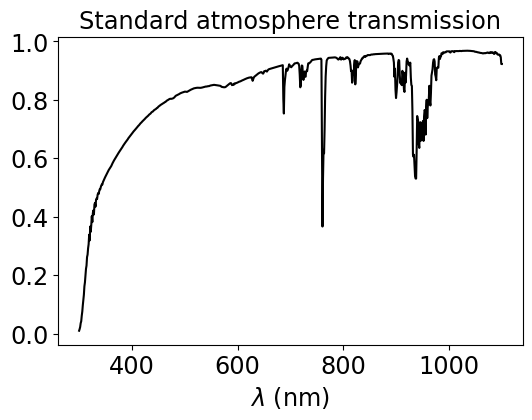

In [19]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

## Pickup an SED

In [20]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [21]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar','photoZ_outliers','sn'] 
sedtypes_not_used = ['stars', 'white_dwarf']
sedtypes = sedtypes 

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [22]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Sdm_template_norm0,galaxies
Ell2_template_norm,galaxies
quasar,quasar
xspec_173,photoZ_outliers
xspec_172,photoZ_outliers
xspec_90,photoZ_outliers
xspec_91,photoZ_outliers
xspec_176,photoZ_outliers


In [23]:
#sed_name = 'xspec_173'
#sed_name = 'quasar'
sed_name = 'Sa_template_norm'
#sed_name = 'Sdm_template_norm0'
#sed_name = 'Ell2_template_norm'
#sed_name = 'sn1a_10.0'
#sed_name = 'sn1a_15.0'
#sed_name = 'sn1a_20.0'

In [24]:
z=0
seds[sed_name].redshift_sed(z)

In [25]:
# Scale spectrum and recalculate magnitudes.
y = 20.0

flux_norm = seds[sed_name].calc_flux_norm(y, pc.bandpass_total_std['y'])
seds[sed_name].multiply_flux_norm(flux_norm)

In [26]:
all_redshifts = np.arange(0,3.5,0.5)
all_seds = []
all_seds_name = []
NSEDS = len(all_redshifts)
hls_colors = sns.color_palette("hls", NSEDS)
for idx,z in enumerate(all_redshifts):
    the_sed = copy.deepcopy(seds[sed_name])
    the_sed.redshift_sed(z)
    all_seds.append(copy.deepcopy(the_sed))
    the_sed_name = f"{sed_name}_{idx}_z{z:.1f}"
    all_seds_name.append(the_sed_name)

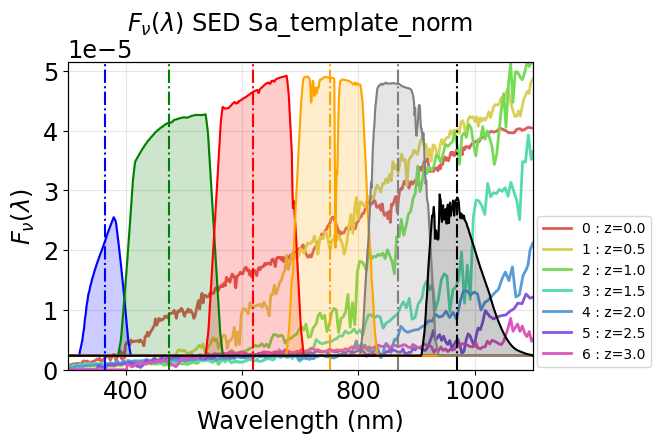

In [27]:
# Plot the seds
all_fmax = np.zeros(NSEDS)
fig, ax = plt.subplots(1,1,figsize=(6,4))

for idx,the_sed in enumerate(all_seds):
    
    wavel,fnu = the_sed.get_sed_fnu()
    z=all_redshifts[idx] 
    label = f"{idx} : z={z:.1f}"
    
    ax.plot(wavel, fnu,"-",color=hls_colors[idx],label=label,lw=2)
    
    indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
    flmax = np.max(fnu[indexes_sel])
    all_fmax[idx] = flmax
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
fmax=np.max(all_fmax)
ax.set_ylim(0,fmax)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$" + f" SED {sed_name}")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])

                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

# Calculations of magnitude and ADC in standard passband

In [28]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = seds[sed_name].calc_mag(pc.bandpass_total_std[f])
    
pd.DataFrame(mags_std, index=[sed_name]).T

,Sa_template_norm
u,23.164294
g,21.581681
r,20.848606
i,20.509627
z,20.226098
y,20.000000


In [29]:
photoparams = set_photometric_parameters(15, 2 , readnoise=None)
adcs_std = {}
for index,f in enumerate(filter_tagnames) :
    adcs_std[f] = seds[sed_name].calc_adu(pc.bandpass_total_std[f],photoparams)
    
pd.DataFrame(adcs_std, index=[sed_name]).T

,Sa_template_norm
u,419.873399
g,6589.597063
r,10723.307763
i,11224.921306
z,10109.371236
y,5996.507357


# Create a series of observations

- vary precipitable water vapor
- keep airmass at 1.2
- other atmospheric parameters are kept constants

In [30]:
PWVMIN = 1
PWVMAX = 9
DPWV= PWVMAX-PWVMIN 
NOBS = 100

In [31]:
all_pwv = DPWV*np.random.rand(NOBS) + PWVMIN

In [32]:
pc.CalculateMultiObs(am0,all_pwv,oz0,ncomp,tau0,beta0)

## Simulate the observations

In [33]:
# constant in zero point
F0AB = 3631*(1*u.Jy).cgs.value
Z0PTconst = 2.5*np.log10((F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime)/(photoparams.gain*const.h.cgs.value))

In [34]:
2.5*np.log10(3631)

8.90006562228223

In [35]:
2.5*np.log10((1*u.Jy).cgs.value)

-57.5

In [36]:
# constant in zero point
#F0AB = 3631*(1*u.Jy).value
#Z0PTconst = 2.5*np.log10(photoparams.gain*const.h.value/(F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime))

In [37]:
df = pd.DataFrame(columns=['count','sed', 'redshift','iobs','pwv',
                           'adcstd_u', 'adcstd_g','adcstd_r','adcstd_i','adcstd_z','adcstd_y',
                           'adcobs_u', 'adcobs_g','adcobs_r','adcobs_i','adcobs_z','adcobs_y',
                           'mistd_u','mistd_g','mistd_r','mistd_i','mistd_z','mistd_y',
                           'miobs_u','miobs_g','miobs_r','miobs_i','miobs_z','miobs_y',
                           'II0ratio_u','II0ratio_g','II0ratio_r','II0ratio_i','II0ratio_z','II0ratio_y',
                           'II1sub_u','II1sub_g','II1sub_r','II1sub_i','II1sub_z','II1sub_y',
                           'magratioII0_u','magratioII0_g','magratioII0_r','magratioII0_i','magratioII0_z','magratioII0_y',
                           'magstd_u','magstd_g','magstd_r','magstd_i','magstd_z','magstd_y',
                           'magobs_u','magobs_g','magobs_r','magobs_i','magobs_z','magobs_y',
                           'z0pt_u','z0pt_g','z0pt_r','z0pt_i','z0pt_z','z0pt_y' 
                          ])


In [ ]:
# loop on SEDs
count=0
for idx_sed,the_sed in enumerate(all_seds):
    #loop on observations 
    for idx_obs,pwv in enumerate(all_pwv):
        # loop in filters
        magstd = np.zeros(NFILT)
        magobs = np.zeros(NFILT)
        adcstd = np.zeros(NFILT)
        adcobs = np.zeros(NFILT)
        mistd = np.zeros(NFILT)
        miobs = np.zeros(NFILT)
        ratioII0 = np.zeros(NFILT)
        subII1 = np.zeros(NFILT)
        magratioII0 = np.zeros(NFILT)
        II0std = np.zeros(NFILT)
        II1std = np.zeros(NFILT)
        Z0PT = np.zeros(NFILT)
        
        for ifilt,f in enumerate(filter_tagnames):
            # standard quanitites
            lsst_band_std = pc.bandpass_total_std[f]
            magstd[ifilt] = all_seds[idx_sed].calc_mag(lsst_band_std)
            adcstd[ifilt] = all_seds[idx_sed].calc_adu(lsst_band_std,photoparams)
            mistd[ifilt] = -2.5*np.log10(adcstd[ifilt])
            II0std[ifilt] = pc.all_II0_std[f]
            II1std[ifilt] = pc.all_II1_std[f]
            # zero point
            Z0PT[ifilt] = 2.5*np.log10(II0std[ifilt])+ Z0PTconst
                
            # non standard quantities    
            lsst_band_obs = pc.coll_bandpass_total_nonstd[idx_obs][f]  
            adcobs[ifilt] = all_seds[idx_sed].calc_adu(lsst_band_obs,photoparams)
            miobs[ifilt] = -2.5*np.log10(adcobs[ifilt])
            magobs[ifilt] = all_seds[idx_sed].calc_mag(lsst_band_obs)
            
            ratioII0[ifilt] = pc.allcollperfilter[f]["II0ratio_nonstd"][idx_obs]  
            subII1[ifilt] = pc.allcollperfilter[f]["II1sub_nonstd"][idx_obs] 
            magratioII0[ifilt] = 2.5*np.log10(ratioII0[ifilt])
        # fill for each observation 
        
        df.loc[count] = [count,all_seds_name[idx_sed], all_redshifts[idx_sed], idx_obs, pwv,
                          adcstd[0],adcstd[1],adcstd[2],adcstd[3],adcstd[4],adcstd[5],
                          adcobs[0],adcobs[1],adcobs[2],adcobs[3],adcobs[4],adcobs[5],
                          mistd[0],mistd[1],mistd[2],mistd[3],mistd[4],mistd[5],
                          miobs[0],miobs[1],miobs[2],miobs[3],miobs[4],miobs[5],
                          ratioII0[0],ratioII0[1],ratioII0[2],ratioII0[3],ratioII0[4],ratioII0[5],
                          subII1[0],subII1[1],subII1[2],subII1[3],subII1[4],subII1[5],
                          magratioII0[0],magratioII0[1],magratioII0[2],magratioII0[3],magratioII0[4],magratioII0[5],
                          magstd[0],magstd[1],magstd[2],magstd[3],magstd[4],magstd[5],
                          magobs[0],magobs[1],magobs[2],magobs[3],magobs[4],magobs[5],
                          Z0PT[0],Z0PT[1],Z0PT[2],Z0PT[3],Z0PT[4],Z0PT[5]  
                        ]
        
        count+=1
                          
        

In [ ]:
df

# If does not calibrate with $II_b^{obs}/II_b^{std}$

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(16,6))
# u
value = df["miobs_u"]-df["mistd_u"]
ax[0,0].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[0],label=filter_tagnames[0] )
# g
value = df["miobs_g"]-df["mistd_g"]
ax[0,1].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[1],label=filter_tagnames[1])
# r
value = df["miobs_r"]-df["mistd_r"]
ax[0,2].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[2],label=filter_tagnames[2])
# i
value = df["miobs_i"]-df["mistd_i"]
ax[1,0].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[3],label=filter_tagnames[3])
# z
value = df["miobs_z"]-df["mistd_z"]
ax[1,1].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[4],label=filter_tagnames[4])
#
value = df["miobs_y"]-df["mistd_y"]
ax[1,2].hist(value,bins=50,range=(-0.15,0.15),facecolor=filter_color[5],label=filter_tagnames[5])
for ix in range(3):
    for iy in range(2):
        ax[iy,ix].legend()
plt.tight_layout()
plt.suptitle("$m_i^{obs}-m_i^{std}$ (mag)"+ f"for SED {sed_name}",fontsize=20,y=1.05)

# If one calibrates with $II_b^{obs}/II_b^{std}$

- assume perfect pwv measurement

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(16,6))
# u
values = df["miobs_u"]+df["magratioII0_u"]-df["mistd_u"]
ax[0,0].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[0],label=filter_tagnames[0] )
# g
values = df["miobs_g"]+df["magratioII0_g"]-df["mistd_g"]
ax[0,1].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[1],label=filter_tagnames[1])
# r
values = df["miobs_r"]+df["magratioII0_r"]-df["mistd_r"]
ax[0,2].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[2],label=filter_tagnames[2])

# i
values = df["miobs_i"]+df["magratioII0_i"]-df["mistd_i"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,0].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[3],label=filter_tagnames[3])
ax[1,0].text(0.05, 0.95, textstr, transform=ax[1,0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#z
values = df["miobs_z"]+df["magratioII0_z"]-df["mistd_z"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,1].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[4],label=filter_tagnames[4])
ax[1,1].text(0.05, 0.95, textstr, transform=ax[1,1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# y
values = df["miobs_y"]+df["magratioII0_y"]-df["mistd_y"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,2].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[5],label=filter_tagnames[5])
ax[1,2].text(0.05, 0.95, textstr, transform=ax[1,2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

for ix in range(3):
    for iy in range(2):
        ax[iy,ix].legend()
plt.tight_layout()
plt.suptitle("$m_i^{obs} + 2.5\log_{10}(II^{obs}/II^{std})-m_i^{std}$ (mag)" +f" for SED {sed_name}",fontsize=20,y=1.05)

## Bias : reconstructed magnitude - true magnitude

- no color correction

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(16,6))

# u
value = df["miobs_u"]+df["magratioII0_u"] + df["z0pt_u"] -df["magstd_u"]
ax[0,0].hist(value,bins=50,range=(-0.01,0.01),facecolor=filter_color[0],label=filter_tagnames[0] )
# g
value = df["miobs_g"]+df["magratioII0_g"] + df["z0pt_g"] -df["magstd_g"]
ax[0,1].hist(df["miobs_g"]+df["magratioII0_g"]-df["mistd_g"],bins=50,range=(-0.01,0.01),facecolor=filter_color[1],label=filter_tagnames[1])
# r
value = df["miobs_r"]+df["magratioII0_r"] + df["z0pt_r"] -df["magstd_r"]
ax[0,2].hist(value,bins=50,range=(-0.01,0.01),facecolor=filter_color[2],label=filter_tagnames[2])

# i
values = df["miobs_i"]+df["magratioII0_i"] + df["z0pt_i"] -df["magstd_i"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,0].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[3],label=filter_tagnames[3])
ax[1,0].text(0.05, 0.95, textstr, transform=ax[1,0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#z
values = df["miobs_z"]+df["magratioII0_z"] + df["z0pt_z"] -df["magstd_z"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,1].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[4],label=filter_tagnames[4])
ax[1,1].text(0.05, 0.95, textstr, transform=ax[1,1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# y
values = df["miobs_y"]+df["magratioII0_y"] + df["z0pt_y"] -df["magstd_y"]
mean = values.describe()["mean"]*1000
std = values.describe()["std"]*1000
textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mean, ),
    r'$\sigma=%.2f$ mmag' % (std, )))
ax[1,2].hist(values,bins=50,range=(-0.01,0.01),facecolor=filter_color[5],label=filter_tagnames[5])
ax[1,2].text(0.05, 0.95, textstr, transform=ax[1,2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

for ix in range(3):
    for iy in range(2):
        ax[iy,ix].legend()
plt.tight_layout()
plt.suptitle("$m_i^{obs} + 2.5\log_{10}(II^{obs}/II^{std}) + Z0PT -m_{TRUE}^{std}$ (mag)" +f" for SED {sed_name}",fontsize=20,y=1.05)